### Loading Packages

In [1]:
import numpy as np # Library that provides functions for mathematical operations and handling arrays
import pandas as pd # Libaray that provides a data frame class and functions to manipulate data frames
import geopandas as gpd # Library that helps to work with spatial data
import matplotlib.pyplot as plt # Function for 2D plotting
from mpl_toolkits.axes_grid1 import make_axes_locatable # Function to create a new axis on a plot
import contextily as cx # Library that helps to add OSM base layer to plots
import plotly.express as px # Library for interactive plotting
# Libraries to allow plotly to be offline and show plots in a jupyter notebook
import plotly.io as pio
import plotly.graph_objects as go
import cufflinks as cf
cf.go_offline()

In [2]:
import rasterio # Library for raster data processing
from rasterio import plot as rioplot # Function to plot raster data
from rasterio.mask import mask # Function to mask raster data using shapefile for zonal statistics
from rasterio.mask import raster_geometry_mask
# linearmodels library provides helps to perform regressions
from linearmodels import PooledOLS # Function to perform pooled OLS regression
from linearmodels import PanelOLS # Function to perform OLS regression on panel data
from linearmodels import BetweenOLS # Function to compute the between estimator of an OLS regression
from linearmodels.panel.results import compare # Function compare results of an OLS regression
import inequality # Library that provides methods for measuring inequality

### Loading Data For Testing

In [3]:
shapefile_path = "D:\\Downloads\\2017_CFS_Metro_Areas_with_FAF\\2017_CFS_Metro_Areas_with_FAF.shp"
gdf = gpd.read_file(shapefile_path)

# For now, for only one FAF zone check NTL
filtered_gdf = gdf[gdf['FAF_Zone']=='300']
polygonsFile = filtered_gdf['geometry']
polygonsFile_bbox = polygonsFile.total_bounds

# Defining start and end years
startYear = 2021
endYear = 2021

# The raster file corresponding to the start year is loaded using the open function in rasterio
# before 2014 the file name is a bit different!
rasterFileFirst = rasterio.open("D:/Downloads/Data_calibrated/Data_calibrated/Harmonized_DN_NTL_"+str(startYear)+"_simVIIRS.tif")
# The bounding box of the vector data is used to crop the raster file
rasterFile_windowFirst = rasterFileFirst.window (* polygonsFile.total_bounds)
#-A Window defines a rectangular region in the raster by specifying the start and stop rows and columns in pixel coordinates.
#-The method .window() expects four separate arguments (e.g., min_x, min_y, max_x, max_y) instead of a single tuple or list.
#-The * operator unpacks the elements of the polygonsFile_bbox variable into separate arguments.
#-By using *polygonsFile_bbox, the tuple's elements are unpacked and passed as four individual arguments to the .window() method.

rasterFile_clippedFirst = rasterFileFirst.read(1 , window = rasterFile_windowFirst)
#It reads a specified band (a layer of data, often representing a specific variable like elevation or reflectance) from the raster.
#The first argument specifies which band of the raster to read.In this case, 1 indicates the first band of the raster file.



# The raster file corresponding to the end year is loaded using the open function in rasterio
rasterFileLast = rasterio.open("D:/Downloads/Data_calibrated/Data_calibrated/Harmonized_DN_NTL_"+str(endYear)+"_simVIIRS.tif")
# The bounding box of the vector data is used to crop the raster file
rasterFile_windowLast = rasterFileLast.window(* polygonsFile.total_bounds)
rasterFile_clippedLast = rasterFileLast.read(1 , window = rasterFile_windowLast)

### Alaska Special Case

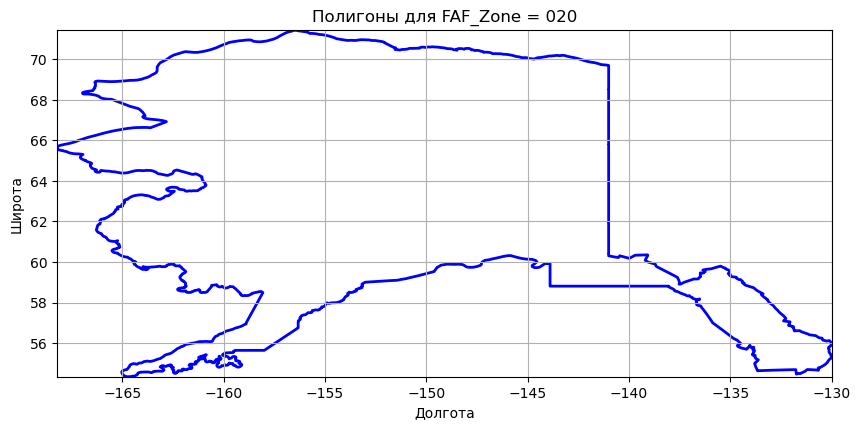

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
b = max(polygonsFile.iloc[0].geoms, key=lambda p: p.area)
polygons = gpd.GeoSeries([b])
polygons.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=2)

ax.set_xlim(polygons.total_bounds[0], polygons.total_bounds[2])
ax.set_ylim(polygons.total_bounds[1], polygons.total_bounds[3])

ax.grid(True)
plt.title("Polygons for FAF_Zone = 020")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()

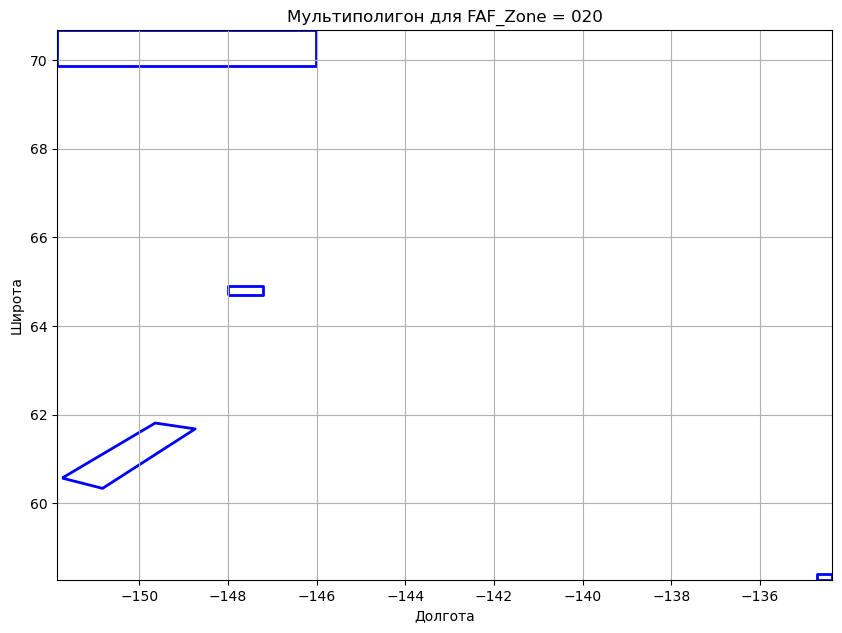

In [ ]:
from shapely.geometry import Polygon, MultiPolygon

polygons = [
    {"type":"Polygon","coordinates":[[[-151.737671,60.571099],[-150.825806,60.338215],[-148.738403,61.679448],[-149.639282,61.812029],[-151.737671,60.571099]]]},
    {"type":"Polygon","coordinates":[[[-148.002319,64.70513],[-148.002319,64.900349],[-147.21405,64.900349],[-147.21405,64.70513],[-148.002319,64.70513]]]},
    {"type":"Polygon","coordinates":[[[-151.853027,69.870729],[-151.853027,70.671461],[-146.008301,70.671461],[-146.008301,69.870729],[-151.853027,69.870729]]]},
    {"type":"Polygon","coordinates":[[[-134.710236,58.278479],[-134.710236,58.413928],[-134.376526,58.413928],[-134.376526,58.278479],[-134.710236,58.278479]]]}
]

shapely_polygons = [Polygon(poly['coordinates'][0]) for poly in polygons]

multipolygon = MultiPolygon(shapely_polygons)

gdf = gpd.GeoDataFrame(geometry=[multipolygon])

fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=2)

ax.set_xlim(gdf.total_bounds[0], gdf.total_bounds[2])
ax.set_ylim(gdf.total_bounds[1], gdf.total_bounds[3])

ax.grid(True)
plt.title("Myltipolygon for FAF_Zone = 020")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()

In [5]:
#rasterFile_clippedLast
#print(rasterFileLast.crs)
#print(polygonsFile.crs)

if polygonsFile.crs != rasterFileLast.crs:
    polygonsFile = polygonsFile.to_crs(rasterFileLast.crs)
#polygonsFile.crs
#rasterFile_window = rasterFileLast.window(*polygonsFile.total_bounds)
#rasterFile_clippedLast = rasterFileLast.read(1, window=rasterFile_window)

#raster_clipped, raster_transform = mask(rasterFileFirst, gpd.GeoSeries([b]), crop=True, nodata=rasterFileFirst.nodata)
raster_clipped, raster_transform = mask(rasterFileFirst, polygonsFile, crop=True, nodata=rasterFileFirst.nodata)


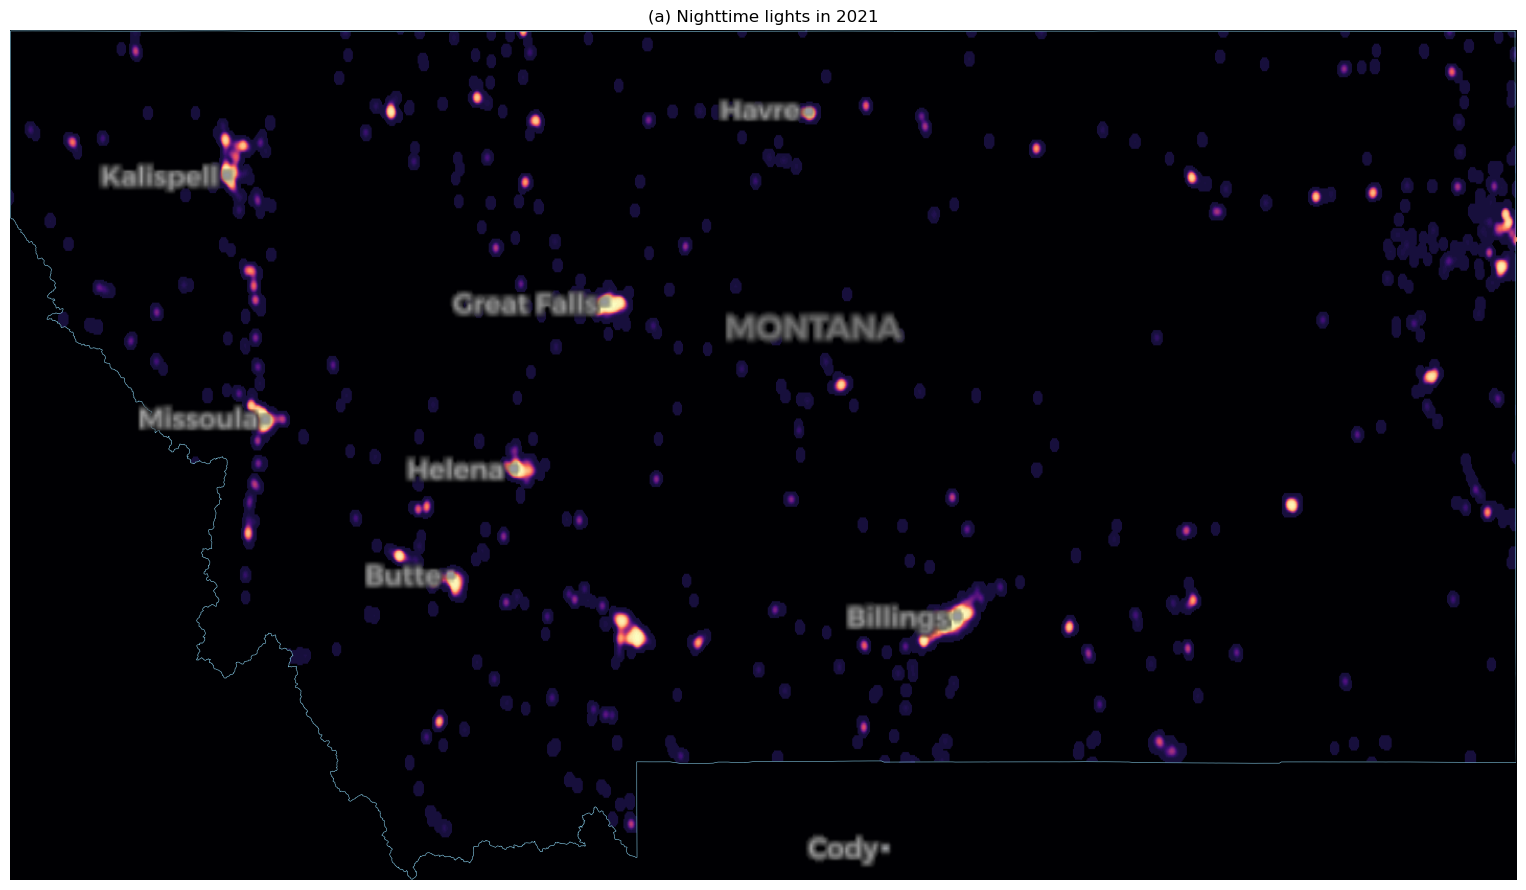

In [6]:
#A figure is initialized with 2 plots arranged side by side. 
#fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize =(12,8)) #For Leningradkaya oblast

fig, ax1 = plt.subplots(nrows=1,ncols=1, figsize =(16,9))
#fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize =(12,8)) #For India
#plt.subplots() creates a figure (fig) with two subplots (ax1 and ax2) arranged in 1 row and 2 columns.
#figsize=(12, 8) sets the size of the figure (width: 12 inches, height: 8 inches).

top_left_x, top_left_y = raster_transform * (0, 0)  # Верхний левый угол
bottom_right_x, bottom_right_y = raster_transform * (raster_clipped.shape[2], raster_clipped.shape[1])  # Нижний правый угол
# The nighttime lights around India for the start year is added
#im1 = ax1.imshow(raster_clipped[0], extent = polygonsFile_bbox [[0 ,2 ,1 ,3]], vmin =0 , vmax =63 , cmap ="magma")
m1 = ax1.imshow(raster_clipped[0], extent=[top_left_x, bottom_right_x, bottom_right_y, top_left_y], vmin=0, vmax=63, cmap="magma")

# ax1.imshow() displays the raster data (rasterFile_clippedFirst) as an image. 
# extent specifies the geographic bounds of the raster, derived from polygonsFile_bbox. The extent parameter expects a list or tuple in the form: 
#extent = [left, right, bottom, top], 
#where left: Minimum x-coordinate (longitude or easting). polygonsFile_bbox already contains [min_x, min_y, max_x, max_y]. 
#The indexing [0, 2, 1, 3] is used to reorder the elements of the bounding box array to match the order required by extent.
#Thus, this ensures that the geographic bounds are passed to extent in the correct order: [left, right, bottom, top].
# vmin and vmax set the color scale range (0 to 63).
# cmap="magma" specifies the colormap.


# State boundaries are overlayed
polygonsFile.boundary.plot (ax=ax1 , color ="skyblue", linewidth = 0.4)
#gpd.GeoSeries([b], crs=polygonsFile.crs).boundary.plot (ax=ax1 , color ="skyblue", linewidth = 0.4)

# Add a Basemap. crs specifies the coordinate reference system of the data. attribution=False disables attribution text.
cx.add_basemap(ax=ax1 , crs = polygonsFile.crs.to_string(), source = cx.providers.CartoDB.DarkMatterOnlyLabels, attribution = False)
#cx.add_basemap(ax=ax1 , crs = gpd.GeoSeries([b], crs=polygonsFile.crs).crs.to_string(), source = cx.providers.CartoDB.DarkMatterOnlyLabels, attribution = False)

#Add a Colorbar
"""     divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right",size="5%",pad=0.05 ) #append_axes() adds an axis for the colorbar to the right of ax1.
cbar1 = plt.colorbar(im1,cax=cax1)
#Add Labels and Title
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude") """
ax1.set_title("(a) Nighttime lights in " + str(startYear))
""" ax1.set_aspect('equal', 'box') """
ax1.set_axis_off()


# # The nighttime lights around India for the last year is plotted
# im2 = ax2.imshow(rasterFile_clippedLast,extent=polygonsFile_bbox[[0,2,1,3]], vmin=0, vmax=63, cmap ="magma")
# #gpd.GeoSeries([b], crs=polygonsFile.crs).boundary.plot (ax=ax2, color ="skyblue", linewidth = 0.4)
# polygonsFile.boundary.plot (ax=ax2, color ="skyblue", linewidth = 0.4)

# cx.add_basemap(ax=ax2, crs=polygonsFile.crs.to_string(), source=cx.providers.CartoDB.DarkMatterOnlyLabels, attribution=False)
#cx.add_basemap(ax=ax2, crs=gpd.GeoSeries([b], crs=polygonsFile.crs).crs.to_string(), source=cx.providers.CartoDB.DarkMatterOnlyLabels, attribution=False)

# """ divider2 = make_axes_locatable(ax2)
# cax2 = divider2.append_axes("right", size ="5%", pad =0.05)
# cbar2 = plt.colorbar(im2, cax = cax2)
# ax2.set_xlabel ("Longitude")
# ax2.set_ylabel ("Latitude") """
# Title of the plot is added
# ax2.set_title("(b) Nighttime lights in " + str (endYear))
# """ ax2.set_aspect('equal', 'box') """
# ax2.set_axis_off()
plt.tight_layout() #adjusts the spacing between subplots to prevent overlap.
# saves the figure as a PNG file with a resolution of 300 DPI:
plt.savefig("D:/Downloads/Data_calibrated/NTL.png", dpi=300 , bbox_inches ="tight") #
plt.show()
plt.close() # closes the figure to free memory.

### Function to derive NTL intensity

In [ ]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.mask import mask

startYear, endYear = 2018, 2021  

def get_sum_of_lights(raster_path, polygon):
    with rasterio.open(raster_path) as src:
        try:
            raster_clipped, _ = mask(src, [polygon], crop=True, nodata=src.nodata)

            # Leave only positive illumination values
            valid_pixels = raster_clipped[raster_clipped > 0]

            # Sum of Lights (SoL)
            sol = valid_pixels.sum()
            
            # Number of non-zero pixels
            num_pixels = valid_pixels.size

            # SoL per pixel
            sol_per_pixel = sol / num_pixels if num_pixels > 0 else np.nan
            
            return sol, sol_per_pixel, num_pixels
        except Exception as e:
            print(f"Error processing polygon: {e}")
            return np.nan, np.nan, 0

# Geodata loading
shapefile_path = "D:\\Downloads\\2017_CFS_Metro_Areas_with_FAF\\2017_CFS_Metro_Areas_with_FAF.shp"
gdf = gpd.read_file(shapefile_path)

# Converting CRS to raster (EPSG:4326)
gdf = gdf.to_crs("EPSG:4326")

# Calculate SoL for each year
for year in range(startYear, endYear + 1):
    raster_path = f"D:/Downloads/Data_calibrated/Data_calibrated/Harmonized_DN_NTL_{year}_simVIIRS.tif"
    
    try:
        with rasterio.open(raster_path) as src:
            raster_crs = src.crs

        if gdf.crs != raster_crs:
            gdf = gdf.to_crs(raster_crs)

        # We get data on SoL, SoL per pixel and the number of pixels
        gdf[f"SoL_{year}"], gdf[f"SoL_per_pixel_{year}"], gdf[f"Num_pixels_{year}"] = zip(*gdf["geometry"].apply(lambda geom: get_sum_of_lights(raster_path, geom)))
        print(f"Completed {year}")

    except Exception as e:
        print(f"Error for {year}: {e}")
        
# Converting CRS to a projection with meters (EPSG:5070 for the USA)
gdf_projected = gdf.to_crs("EPSG:5070")
gdf["Area_km2"] = gdf_projected["geometry"].area / 1e6  # площадь в км²

# Sol density per km^2 (if needed)
for year in range(startYear, endYear + 1):

    gdf[f"SoL_density_{year}"] = np.log(gdf[f"SoL_{year}"] / gdf["Area_km2"])
    
    # Normalize (if needed)
    min_val = gdf[f"SoL_density_{year}"].min()
    max_val = gdf[f"SoL_density_{year}"].max()
    gdf[f"SoL_scaled_{year}"] = 1 * (gdf[f"SoL_density_{year}"] - min_val) / (max_val - min_val)



Completed 2018
Completed 2019
Completed 2020
Completed 2021


In [4]:
gdf.drop(columns=["geometry"]).to_csv("FAF_NTL.csv", index=False)

### Checking Correlation Between GDP and SoL

In [7]:
GDP_NTL = pd.read_excel("D:\\Downloads\\GDP_NTL.xlsx") 

In [8]:
mean_data = GDP_NTL.groupby('dms_orig').agg({'GDP_orig': 'mean', 'SoL_orig': 'mean'}).reset_index()
mean_data

,dms_orig,GDP_orig,SoL_orig
0,11,72538.39225,497081.50
1,12,28967.64975,232658.00
2,19,124018.20800,1683639.25
3,20,51661.00000,10967070.25
4,41,275117.92350,651425.00
...,...,...,...
127,539,102285.89350,623005.50
128,540,76221.90000,1014023.75
129,551,120929.44925,509918.75
130,559,208839.00075,2187868.50


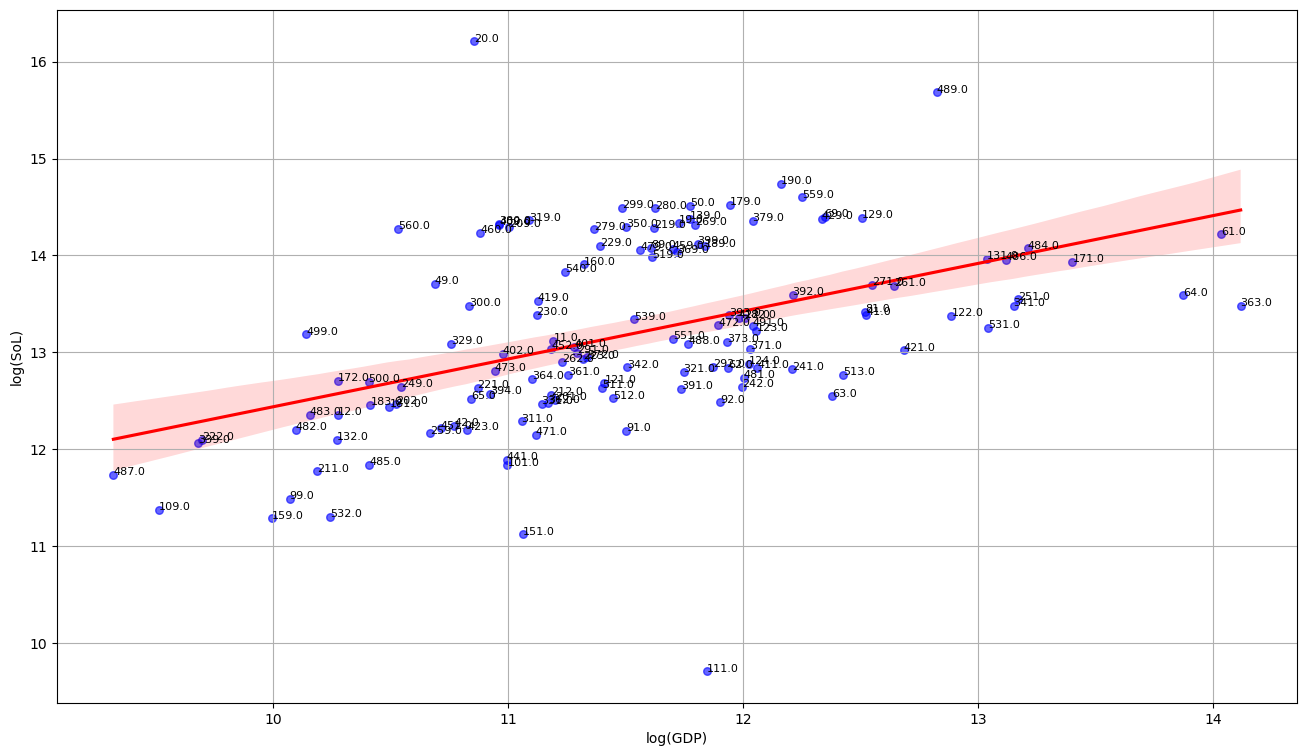

In [9]:
import numpy as np
import seaborn as sns

filtered_data = mean_data

plt.figure(figsize=(16, 9))
sns.regplot(
    data=filtered_data,
    x=np.log(filtered_data['GDP_orig']),
    y=np.log(filtered_data['SoL_orig']),
    scatter_kws={'color': 'blue', 'alpha': 0.6, 's': 30},
    line_kws={'color': 'red'}
)

for i, row in filtered_data.iterrows():
    plt.text(np.log(row['GDP_orig']), np.log(row['SoL_orig']), 
             row['dms_orig'], fontsize=8)

#plt.title("log(SoL) vs log(GDP)")
plt.xlabel("log(GDP)")
plt.ylabel("log(SoL)")
plt.grid(True)

plt.show()

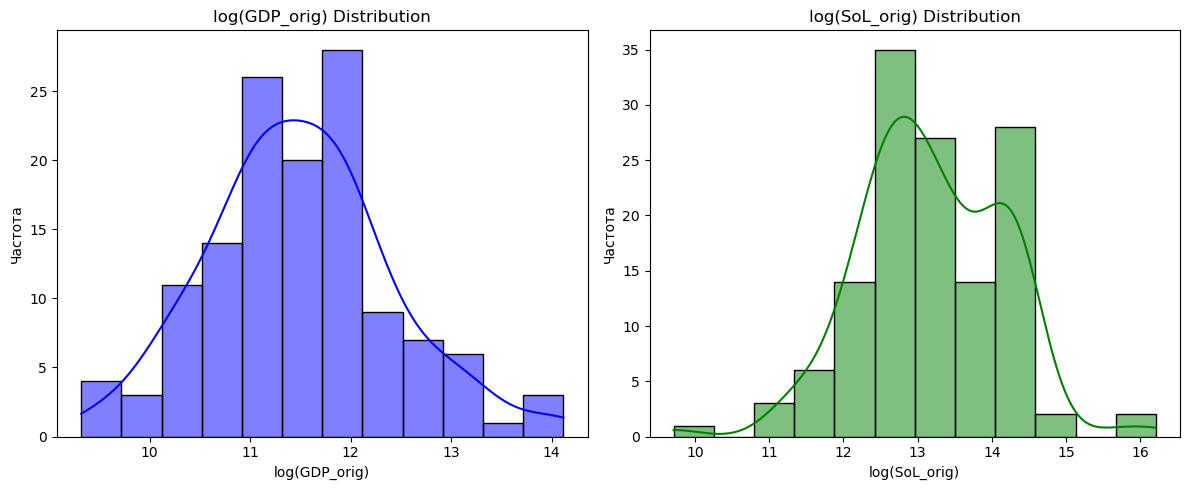

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(np.log(filtered_data['GDP_orig']), kde=True, color='blue')
plt.title('log(GDP_orig) Distribution')
plt.xlabel('log(GDP_orig)')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.histplot(np.log(filtered_data['SoL_orig']), kde=True, color='green')
plt.title('log(SoL_orig) Distribution')
plt.xlabel('log(SoL_orig)')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

In [11]:
import scipy.stats as stats
# Shapiro–Wilk test for normality
_, p_gdp = stats.shapiro(np.log(filtered_data['GDP_orig']))
_, p_sol = stats.shapiro(np.log(filtered_data['SoL_orig']))

print(f"P-value (GDP): {p_gdp:.3f}")  # >0.05 → normal
print(f"P-value (SoL): {p_sol:.3f}")  # >0.05 → normal

P-value (GDP): 0.307
P-value (SoL): 0.029


In [12]:
pearson_corr, p_value = stats.pearsonr(np.log(filtered_data['GDP_orig']), np.log(filtered_data['SoL_orig']))

print(f"Pearson Corr.: {pearson_corr:.3f}")
print(f"P-value: {p_value:.3f}")

Pearson Corr.: 0.467
P-value: 0.000


In [13]:
spearman_corr, p_value = stats.spearmanr(filtered_data['GDP_orig'], filtered_data['SoL_orig'])
print(f"Spearman corr.: {spearman_corr:.3f}")
print(f"P-value: {p_value:.3f}")

Spearman corr.: 0.527
P-value: 0.000


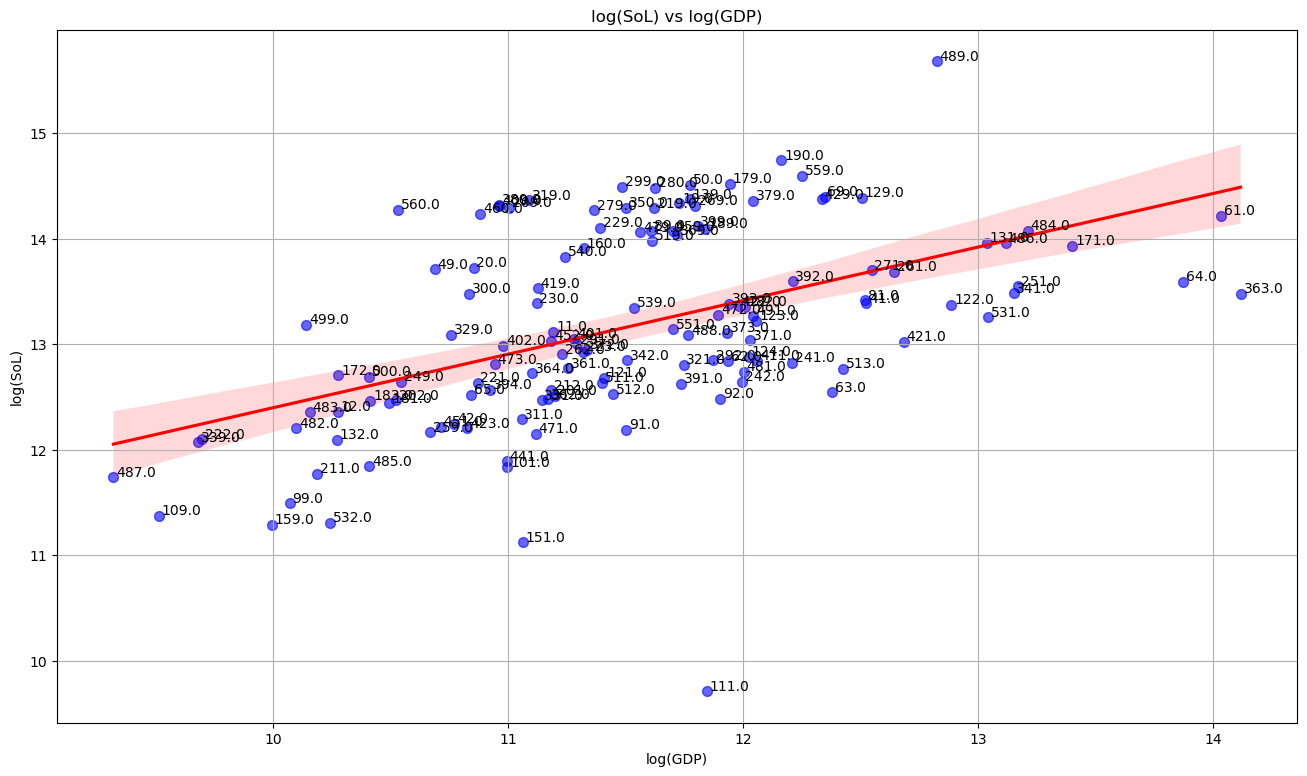

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Replace values for Alaska
mean_sol = np.mean([940249, 865241, 756057, 1092499])

filtered_data.loc[filtered_data['dms_orig'] == 20, 'SoL_orig'] = mean_sol

plt.figure(figsize=(16, 9))
sns.regplot(
    data=filtered_data,
    x=np.log(filtered_data['GDP_orig']),
    y=np.log(filtered_data['SoL_orig']),
    scatter_kws={'color': 'blue', 'alpha': 0.6, 's': 50},
    line_kws={'color': 'red'}
)

for i, row in filtered_data.iterrows():
    plt.text(np.log(row['GDP_orig']) + 0.012,  
             np.log(row['SoL_orig']) + 0.012,  
             row['dms_orig'], fontsize=10)

plt.title("log(SoL) vs log(GDP)")
plt.xlabel("log(GDP)")
plt.ylabel("log(SoL)")
plt.grid(True)
plt.show()

In [ ]:
import scipy.stats as stats

_, p_gdp = stats.shapiro(np.log(filtered_data['GDP_orig']))
_, p_sol = stats.shapiro(np.log(filtered_data['SoL_orig']))

print(f"P-value (GDP): {p_gdp:.3f}")  # >0.05 → нормальное
print(f"P-value (SoL): {p_sol:.3f}")  # >0.05 → нормальное

P-value (GDP): 0.307
P-value (SoL): 0.017


In [16]:
spearman_corr, p_value = stats.spearmanr(filtered_data['GDP_orig'], filtered_data['SoL_orig'])
print(f"Spearman Corr.: {spearman_corr:.3f}")
print(f"P-value: {p_value:.3f}")

Spearman Corr.: 0.537
P-value: 0.000


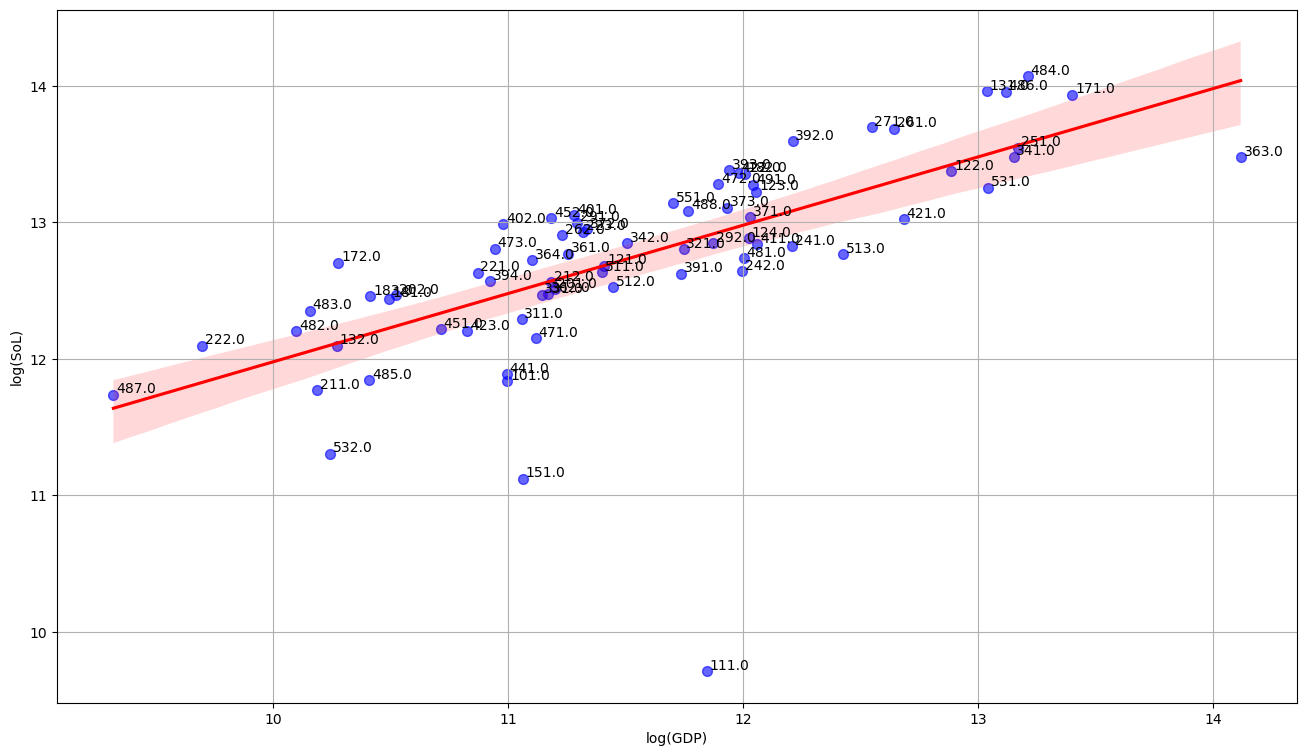

In [17]:
selected_dms = ['011', '012', '041', '042', '061', '062', '063', '064', '065', 
               '081', '091', '092', '101', '111', '121', '122', '123', '124', 
               '131', '132', '151', '171', '172', '181', '182', '183', '201', 
               '202', '211', '212', '221', '222', '223', '241', '242', '251', 
               '261', '262', '271', '291', '292', '311', '321', '331', '341', 
               '342', '361', '362', '363', '364', '371', '372', '373', '391', 
               '392', '393', '394', '401', '402', '411', '421', '422', '423', 
               '441', '451', '452', '471', '472', '473', '481', '482', '483', 
               '484', '485', '486', '487', '488', '491', '511', '512', '513', 
               '531', '532', '551']
filtered_data = mean_data[mean_data['dms_orig'].astype(str).isin(selected_dms)]
if len(filtered_data) > 0:
    plt.figure(figsize=(16, 9))
    sns.regplot(
        data=filtered_data,
        x=np.log(filtered_data['GDP_orig']),
        y=np.log(filtered_data['SoL_orig']),
        scatter_kws={'color': 'blue', 'alpha': 0.6, 's': 50},
        line_kws={'color': 'red'}
    )
    
    for i, row in filtered_data.iterrows():
        plt.text(np.log(row['GDP_orig']) + 0.012,  
             np.log(row['SoL_orig']) + 0.012, 
             row['dms_orig'], fontsize=10)
    
    plt.xlabel("log(GDP)")
    plt.ylabel("log(SoL)")
    plt.grid(True)
    plt.show()

In [18]:
_, p_gdp = stats.shapiro(np.log(filtered_data['GDP_orig']))
_, p_sol = stats.shapiro(np.log(filtered_data['SoL_orig']))

print(f"P-value (GDP): {p_gdp:.3f}")  # >0.05 → normal
print(f"P-value (SoL): {p_sol:.3f}")  # >0.05 → normal

P-value (GDP): 0.534
P-value (SoL): 0.001


In [19]:
pearson_corr, p_value = stats.pearsonr(np.log(filtered_data['GDP_orig']), np.log(filtered_data['SoL_orig']))

print(f"Pearson Corr.: {pearson_corr:.3f}")
print(f"P-value: {p_value:.3f}")

Pearson Corr.: 0.674
P-value: 0.000


In [20]:
spearman_corr, p_value = stats.spearmanr(filtered_data['GDP_orig'], filtered_data['SoL_orig'])
print(f"Spearman corr.: {spearman_corr:.3f}")
print(f"P-value: {p_value:.3f}")

Spearman corr.: 0.821
P-value: 0.000
